In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = 999

sns.set_style('white')

In [2]:
#pd.options.display.max_rows = 100

In [3]:
df = pd.read_csv('census_income_2019.csv', compression = 'zip')
df.head()

,PWGTP,WGTP,PINCP,WKHP,WAGP,AGEP,FER,DIS,COW,CPLT,ADJINC,CIT,POBP,PARTNER,SEX,RAC1P,SCHL,OCCP,NAICSP,SERIALNO,SPORDER
0,71,0,63000,80,63000,35,0,2,1,0,1.010145,1,18,-1,1,1,17,6250,23,2019GQ0000001,1
1,67,0,0,0,0,25,0,2,0,0,1.010145,1,48,-1,1,1,12,9,-1,2019GQ0000004,1
2,24,0,2000,15,2000,21,2,2,2,0,1.010145,5,229,-1,2,6,19,4740,611M1,2019GQ0000007,1
3,52,0,0,0,0,49,0,2,1,0,1.010145,1,6,-1,1,1,21,110,722Z,2019GQ0000010,1
4,28,0,6000,15,6000,18,2,2,1,0,1.010145,1,6,-1,2,1,16,4110,722Z,2019GQ0000013,1


In [4]:
df.shape

(3239553, 21)

##### Update Column Names

In [5]:
org_vars = """PINCP
WAGP
INTP
ADJINC
PWGTP
OCCP
NAICSP
WKHP
AGEP
SEX
FER
CPLT
PARTNER
COW
RAC1P
POBP
CIT
SCHL
DIS
SERIALNO
SPORDER
WAOB""".split("\n")

In [6]:
uptd_vars = """INCOME
SALARY
INTEREST_DIV
ADJINC
FNLWGT
OCCUPATION
WORK_INDUSTRY
WKLY_HRS
AGE
SEX
MOM
COUPLE
PARTNER
WORK_CLASS
RACE
POB_DETAIL
CITIZENSHIP
EDUCATION
DIS
SERIALNO
PERSON_NO
POB_WORLD""".split("\n")

In [7]:
vars_dict = dict(zip(org_vars, uptd_vars))
# vars_dict #Uncomment to view

In [8]:
df = df.rename(columns=vars_dict)
df.head() #Sanity Check

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,DIS,WORK_CLASS,COUPLE,ADJINC,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY,SERIALNO,PERSON_NO
0,71,0,63000,80,63000,35,0,2,1,0,1.010145,1,18,-1,1,1,17,6250,23,2019GQ0000001,1
1,67,0,0,0,0,25,0,2,0,0,1.010145,1,48,-1,1,1,12,9,-1,2019GQ0000004,1
2,24,0,2000,15,2000,21,2,2,2,0,1.010145,5,229,-1,2,6,19,4740,611M1,2019GQ0000007,1
3,52,0,0,0,0,49,0,2,1,0,1.010145,1,6,-1,1,1,21,110,722Z,2019GQ0000010,1
4,28,0,6000,15,6000,18,2,2,1,0,1.010145,1,6,-1,2,1,16,4110,722Z,2019GQ0000013,1


In [9]:
df.head()

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,DIS,WORK_CLASS,COUPLE,ADJINC,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY,SERIALNO,PERSON_NO
0,71,0,63000,80,63000,35,0,2,1,0,1.010145,1,18,-1,1,1,17,6250,23,2019GQ0000001,1
1,67,0,0,0,0,25,0,2,0,0,1.010145,1,48,-1,1,1,12,9,-1,2019GQ0000004,1
2,24,0,2000,15,2000,21,2,2,2,0,1.010145,5,229,-1,2,6,19,4740,611M1,2019GQ0000007,1
3,52,0,0,0,0,49,0,2,1,0,1.010145,1,6,-1,1,1,21,110,722Z,2019GQ0000010,1
4,28,0,6000,15,6000,18,2,2,1,0,1.010145,1,6,-1,2,1,16,4110,722Z,2019GQ0000013,1


In [10]:
#checking for duplicates
df.duplicated().sum()

0

In [11]:
##Remove MOM, DIS, SERIALNO and PERSON_NO here?
df = df.drop(['DIS','ADJINC','SERIALNO', 'PERSON_NO'], axis=1)

# Cleaning

In [12]:
# narrow down data to adults over the 17 years old
df = df[df.AGE > 17]

In [13]:
df.shape

(2599171, 17)

In [14]:
# narrow down data to adults who worked in the past 12 months
df = df[df.WKLY_HRS > 0]

In [15]:
df.shape

(1659727, 17)

In [16]:
df.describe()

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,WORK_CLASS,COUPLE,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION
count,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06
mean,1.033513e+02,9.579058e+01,6.058823e+04,3.839128e+01,5.189937e+04,4.390527e+01,5.906477e-01,2.103359e+00,8.639788e-01,1.519284e+00,6.538772e+01,2.079902e-01,1.478681e+00,1.873518e+00,1.871658e+01,4.088068e+03
std,9.061065e+01,8.493126e+01,7.691692e+04,1.310493e+01,6.724644e+04,1.525340e+01,9.042176e-01,1.827131e+00,8.056928e-01,1.227446e+00,9.273321e+01,8.872759e-01,4.995454e-01,2.079837e+00,3.274921e+00,2.685733e+03
min,1.000000e+00,0.000000e+00,-1.020000e+04,1.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01
25%,5.100000e+01,4.800000e+01,2.100000e+04,3.500000e+01,1.450000e+04,3.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.800000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01,2.040000e+03
50%,7.900000e+01,7.400000e+01,4.024000e+04,4.000000e+01,3.540000e+04,4.400000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.600000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.900000e+01,4.110000e+03
75%,1.230000e+02,1.160000e+02,7.200000e+04,4.200000e+01,6.500000e+04,5.600000e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,4.800000e+01,0.000000e+00,2.000000e+00,1.000000e+00,2.100000e+01,5.740000e+03
max,2.408000e+03,2.377000e+03,1.629000e+06,9.900000e+01,7.170000e+05,9.600000e+01,2.000000e+00,8.000000e+00,4.000000e+00,5.000000e+00,5.540000e+02,4.000000e+00,2.000000e+00,9.000000e+00,2.400000e+01,9.830000e+03


#### Checking relationships between features before feature creation

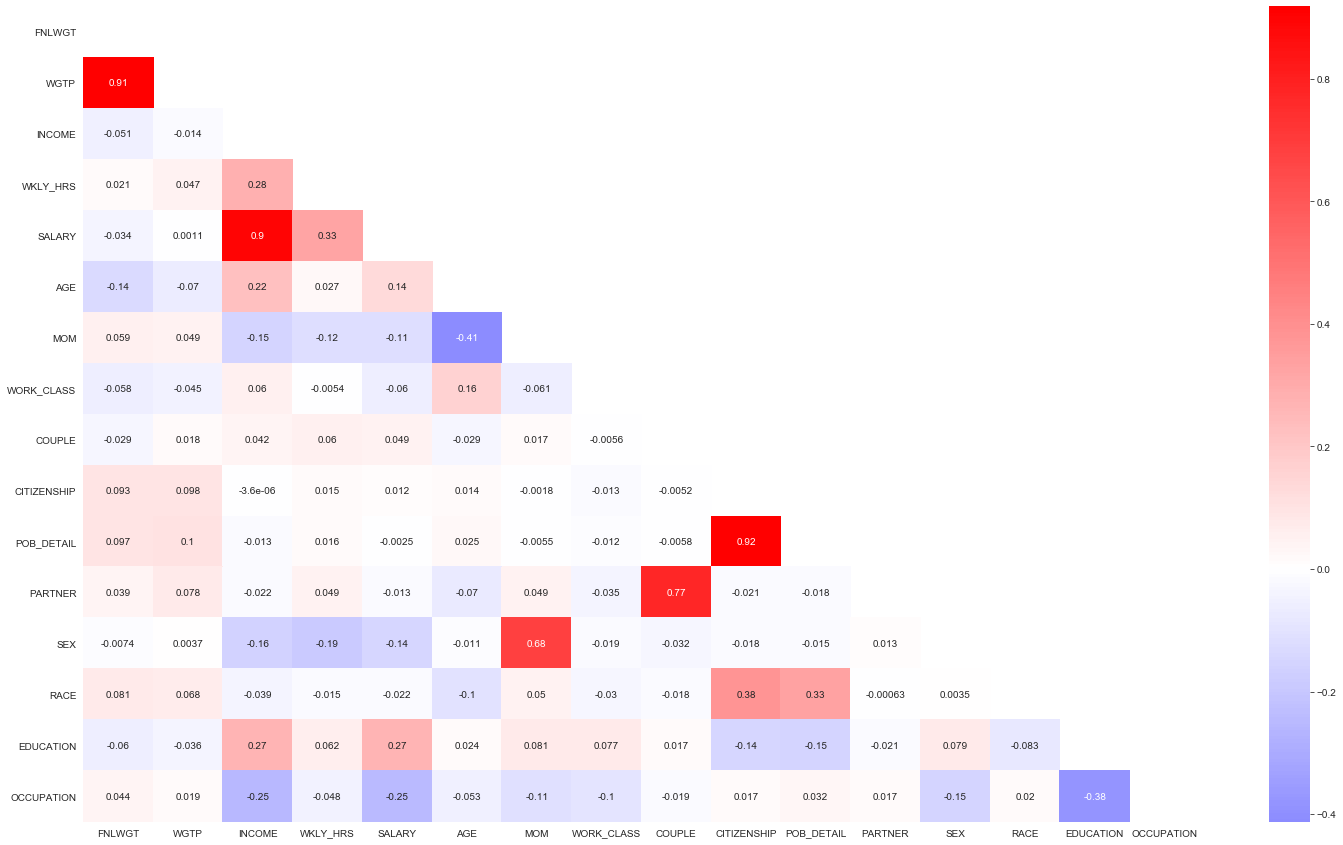

In [17]:
#create a heatmap to visualize the correlations
fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

## Feature Creation

### **CITIZENSHIP**

In [18]:
# 1 indicating born in US, 0 indicating born outside of US
df['CITIZENSHIP'] = np.where(df['CITIZENSHIP']==1 , 1, 0)

### **EDUCATION**

In [19]:
conditions = [ 
    (df['EDUCATION'] <= 15), # Undergraduate
    ((df['EDUCATION'] >= 16) & (df['EDUCATION'] <= 19)), # High School graduate without college degree
    (df['EDUCATION'] == 20), # Associate's Degree
    (df['EDUCATION'] == 21), # Bachelor's Degree
    (df['EDUCATION'] == 22), # Master's Degree
    (df['EDUCATION'] == 23), # Professional degree beyond Master's
    (df['EDUCATION'] == 24), # Doctorate Degree 
]

choices = [
    "No High School Diploma or GED",
    'High School', 
    "Associate's", 
    "Bachelor's",
    "Master's", 
    "Professional Other", 
    "Doctorate", 
]

df['EDUCATION'] = np.select(conditions, choices, default='NA')


In [20]:
# Sanity Check
print('Count:')
print(df.EDUCATION.value_counts())
print('-'*40)
print('Proportion:')
print(df.EDUCATION.value_counts(normalize=True))

Count:
High School                      769592
Bachelor's                       378817
Master's                         166793
Associate's                      154487
No High School Diploma or GED    118434
Professional Other                42571
Doctorate                         29033
Name: EDUCATION, dtype: int64
----------------------------------------
Proportion:
High School                      0.463686
Bachelor's                       0.228241
Master's                         0.100494
Associate's                      0.093080
No High School Diploma or GED    0.071358
Professional Other               0.025649
Doctorate                        0.017493
Name: EDUCATION, dtype: float64


### **RACE**

*White/Non-White*

In [21]:
#Creating a new feature RACE2
conditions = [ 
    (df['RACE'] == 1), # White
    (df['RACE'] <= 19)] # Non-White

choices = ["White","Non-White"]

df['RACE2'] = np.select(conditions, choices, default='NA')


In [22]:
# Sanity Check
print('Count:')
print(df.RACE2.value_counts())
print('-'*40)
print('Proportion:')
print(df.RACE2.value_counts(normalize=True))

Count:
White        1296635
Non-White     363092
Name: RACE2, dtype: int64
----------------------------------------
Proportion:
White        0.781234
Non-White    0.218766
Name: RACE2, dtype: float64


*White, Black, Asian, Native American, Other*

In [23]:
#Creating a new feature RACE3
conditions = [ 
    (df['RACE'] == 1), # White
    (df['RACE'] == 2), # Black
    (df['RACE'] == 6), # Asian
    ((df['RACE'] == 3)|(df['RACE'] == 4)|(df['RACE'] == 5)|(df['RACE'] == 7)), # Native American
    ((df['RACE'] == 8)|(df['RACE'] == 9)) # Other
]
choices = ['White',
           'Black',
           'Asian',
           'Native American',
           'Other']

df['RACE3'] = np.select(conditions, choices, default='NA')

In [24]:
# Sanity Check
print('Count:')
print(df.RACE3.value_counts())
print('-'*40)
print('Proportion:')
print(df.RACE3.value_counts(normalize=True))

Count:
White              1296635
Black               143878
Other               101755
Asian               100462
Native American      16997
Name: RACE3, dtype: int64
----------------------------------------
Proportion:
White              0.781234
Black              0.086688
Other              0.061308
Asian              0.060529
Native American    0.010241
Name: RACE3, dtype: float64


### **AGE**

*Create a new feature indicating "older than 65"

In [25]:
#Creating a new feature AGE_DIV
conditions = [ 
    (df['AGE'] <= 65),
    (df['AGE'] > 65)
]

choices = ['<65 yrs',
           '>65 yrs'
]
df['AGE_DIV'] = np.select(conditions, choices, default='NA')

In [26]:
# Sanity Check
df.AGE_DIV.value_counts()

<65 yrs    1533545
>65 yrs     126182
Name: AGE_DIV, dtype: int64

### **OCCUPATION**

In [27]:
# Binning Occupations

conditions = [ 
    ((df['OCCUPATION'] >= 10) & (df['OCCUPATION'] <= 440)), #MGR
    ((df['OCCUPATION'] >= 500) & (df['OCCUPATION'] <= 750)), #BUS
    ((df['OCCUPATION'] >= 800) & (df['OCCUPATION'] <= 960)), #FIN
    ((df['OCCUPATION'] >= 1005) & (df['OCCUPATION'] <= 1240)), #CMM
    ((df['OCCUPATION'] >= 1305) & (df['OCCUPATION'] <= 1560)), #ENG
    ((df['OCCUPATION'] >= 1600) & (df['OCCUPATION'] <= 1980)), #SCI
    ((df['OCCUPATION'] >= 2001) & (df['OCCUPATION'] <= 2060)), #CMS 
    ((df['OCCUPATION'] >= 2100) & (df['OCCUPATION'] <= 2180)), #LGL
    ((df['OCCUPATION'] >= 2205) & (df['OCCUPATION'] <= 2555)), #EDU
    ((df['OCCUPATION'] >= 2600) & (df['OCCUPATION'] <= 2920)), #ENT 
    ((df['OCCUPATION'] >= 3000) & (df['OCCUPATION'] <= 3550)), #MED
    ((df['OCCUPATION'] >= 3610) & (df['OCCUPATION'] <= 3655)), #HLS
    ((df['OCCUPATION'] >= 3700) & (df['OCCUPATION'] <= 3960)), #PRT 
    ((df['OCCUPATION'] >= 4000) & (df['OCCUPATION'] <= 4160)), #EAT
    ((df['OCCUPATION'] >= 4200) & (df['OCCUPATION'] <= 4255)), #CLN
    ((df['OCCUPATION'] >= 4330) & (df['OCCUPATION'] <= 4655)), #PRS
    ((df['OCCUPATION'] >= 4700) & (df['OCCUPATION'] <= 4965)), #SAL
    ((df['OCCUPATION'] >= 5000) & (df['OCCUPATION'] <= 5940)), #OFF
    ((df['OCCUPATION'] >= 6005) & (df['OCCUPATION'] <= 6130)), #FFF
    ((df['OCCUPATION'] >= 6200) & (df['OCCUPATION'] <= 6765)), #CON
    ((df['OCCUPATION'] >= 6800) & (df['OCCUPATION'] <= 6950)), #EXT
    ((df['OCCUPATION'] >= 7000) & (df['OCCUPATION'] <= 7640)), #RPR
    ((df['OCCUPATION'] >= 7700) & (df['OCCUPATION'] <= 8990)), #PRD
    ((df['OCCUPATION'] >= 9005) & (df['OCCUPATION'] <= 9760)), #TRN
    ((df['OCCUPATION'] >= 9800) & (df['OCCUPATION'] <= 9830)), #MIL
]

choices = [
    'MGR', 
    'BUS', 
    'FIN',
    'CMM', 
    'ENG', 
    'SCI',
    'CMS', 
    'LGL', 
    'EDU',
    'ENT', 
    'MED', 
    'HLS',
    'PRT', 
    'EAT', 
    'CLN',
    'PRS', 
    'SAL', 
    'OFF',
    'FFF', 
    'CON', 
    'EXT',
    'RPR',
    'PRD', 
    'TRN', 
    'MIL',
]

df['OCCUPATION'] = np.select(conditions, choices, default='NA')

In [28]:
# df.OCCUPATION.value_counts() #Sanity Check

### **WORK_INDUSTRY**

In [30]:
# Removing letters from values 
df['WORK_INDUSTRY'] = df.WORK_INDUSTRY.apply(lambda x: ''.join([num for num in x if num.isnumeric()]))


In [31]:
#lambda
df['WORK_INDUSTRY'] = df['WORK_INDUSTRY'].apply(
    lambda x:'99' if '9281' in x else x)

In [32]:
# Sanity Check
#df.WORK_INDUSTRY.unique()

array(['23', '6111', '722', '337', '56173', '447', '921', '99', '5121',
       '623', '4481', '42393', '7224', '5412', '44511', '713', '813',
       '32711', '3256', '4441', '622', '531', '561', '51912', '3', '5241',
       '8131', '5417', '443142', '493', '3352', '336', '8121', '721',
       '111', '2211', '4411', '6243', '8111', '6244', '442', '4244',
       '5616', '4511', '6113', '443141', '44512', '45221', '712', '115',
       '5613', '331', '3231', '6112', '488', '92', '5416', '3272', '6214',
       '3121', '484', '45121', '5617', '112', '6241', '5614', '6216',
       '5411', '446', '4', '483', '492', '6231', '3112', '8123', '51111',
       '812111', '522', '6211', '5615', '4539', '521', '814', '811192',
       '5419', '71395', '4531', '44611', '6222', '44821', '3365', '311',
       '6242', '4452', '7211', '621', '4533', '4523', '4236', '45322',
       '562', '9211', '3391', '3399', '7115', '517311', '4853', '8129',
       '7112', '333', '3219', '311811', '3118', '335', '33311', 

In [33]:
def first_2_digits(num):
    return int(num[:2])
df['WORK_INDUSTRY'] = df.WORK_INDUSTRY.apply(first_2_digits).sort_values()
# df.WORK_INDUSTRY.value_counts().sort_index() #Sanity Check

In [35]:
# Binning Industry

conditions = [ 
    (df['WORK_INDUSTRY'] == 11), #AGR
    (df['WORK_INDUSTRY'] == 21), #EXT
    (df['WORK_INDUSTRY'] == 22), #UTL
    (df['WORK_INDUSTRY'] == 23), #CON
    ((df['WORK_INDUSTRY'] >= 30) & (df['WORK_INDUSTRY'] <= 33)| (df['WORK_INDUSTRY'] == 3)), #MFG  ADD 3
    ((df['WORK_INDUSTRY'] == 42) | (df['WORK_INDUSTRY'] == 4)), #WHL
    ((df['WORK_INDUSTRY'] >= 44) & (df['WORK_INDUSTRY'] <= 45)), #RET ADD 4
    ((df['WORK_INDUSTRY'] >= 48) & (df['WORK_INDUSTRY'] <= 49)), #TRN
    (df['WORK_INDUSTRY'] == 51), # INF
    ((df['WORK_INDUSTRY'] >= 52) & (df['WORK_INDUSTRY'] <= 53)), # FIN
    ((df['WORK_INDUSTRY'] >= 54) & (df['WORK_INDUSTRY'] <= 56)), #PRF
    (df['WORK_INDUSTRY'] == 61), #EDU
    (df['WORK_INDUSTRY'] == 62), #MED/SCA
    ((df['WORK_INDUSTRY'] >= 71) & (df['WORK_INDUSTRY'] <= 72)), #ENT
    (df['WORK_INDUSTRY'] == 81), # SRV
    ((df['WORK_INDUSTRY'] >= 921) & (df['WORK_INDUSTRY'] <= 923)), #ADM
    (df['WORK_INDUSTRY'] == 99), #MIL
]

choices = [
    'AGR',
    'EXT',
    'UTL',
    'CON',
    'MFG',
    'WHL',
    'RET',
    'TRN',
    'INF',
    'FIN',
    'PRF',
    'EDU',
    'MED',
    'ENT',
    'SRV',
    'ADM',
    'MIL'
]

df['WORK_INDUSTRY'] = np.select(conditions, choices, default='NA')

In [36]:
# Sanity Check
df.WORK_INDUSTRY.value_counts()
# df.WORK_INDUSTRY.isnull().sum()

MED    222550
PRF    197150
EDU    172681
RET    167656
MFG    165671
ENT    146322
CON    109624
FIN    106705
SRV     79758
NA      78940
TRN     74078
WHL     46533
INF     31378
AGR     25961
UTL     14284
MIL     12095
EXT      8341
Name: WORK_INDUSTRY, dtype: int64

**Checking out features after engineering**

# Exploring Target Variable

In [37]:
df['TARGET'] = np.where(df.INCOME > 65000, '>65k', '<=65k')
df.TARGET.value_counts()

<=65k    1183289
>65k      476438
Name: TARGET, dtype: int64

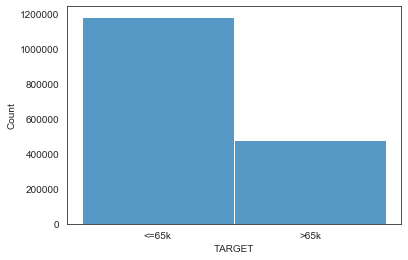

In [38]:
sns.histplot(data = df, x="TARGET")
plt.show()

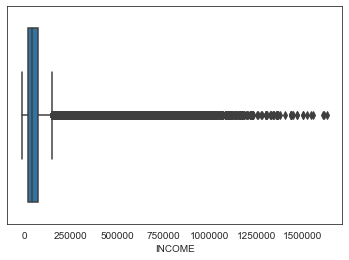

In [39]:
sns.boxplot(x=df.INCOME)


In [40]:
df.INCOME.describe()

count    1.659727e+06
mean     6.058823e+04
std      7.691692e+04
min     -1.020000e+04
25%      2.100000e+04
50%      4.024000e+04
75%      7.200000e+04
max      1.629000e+06
Name: INCOME, dtype: float64

In [41]:
df.INCOME

0           63000
2            2000
4            6000
11           3200
13            500
            ...  
3239548    150000
3239549     27000
3239550     75000
3239551     57000
3239552     55000
Name: INCOME, Length: 1659727, dtype: int64

In [42]:
df[df.INCOME > 100]['INCOME'].describe()

count    1.656282e+06
mean     6.071761e+04
std      7.694438e+04
min      1.040000e+02
25%      2.100000e+04
50%      4.050000e+04
75%      7.200000e+04
max      1.629000e+06
Name: INCOME, dtype: float64

In [43]:
df.SALARY.describe()

count    1.659727e+06
mean     5.189937e+04
std      6.724644e+04
min      0.000000e+00
25%      1.450000e+04
50%      3.540000e+04
75%      6.500000e+04
max      7.170000e+05
Name: SALARY, dtype: float64

# Additional EDA

In [44]:
df.EDUCATION.value_counts()

High School                      769592
Bachelor's                       378817
Master's                         166793
Associate's                      154487
No High School Diploma or GED    118434
Professional Other                42571
Doctorate                         29033
Name: EDUCATION, dtype: int64

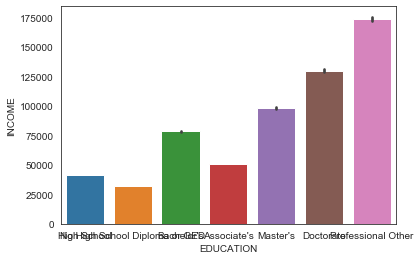

In [45]:
sns.barplot(data=df, x='EDUCATION', y='INCOME')

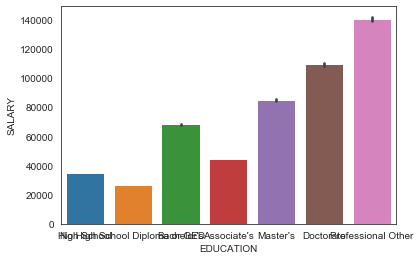

In [46]:
sns.barplot(data=df, x='EDUCATION', y='SALARY')

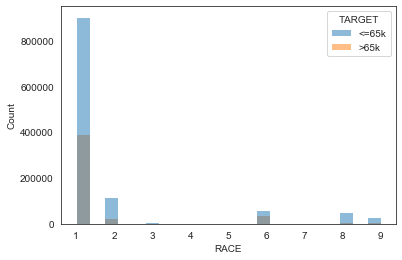

In [47]:
sns.histplot(data = df, x="RACE", hue = "TARGET")
plt.show()

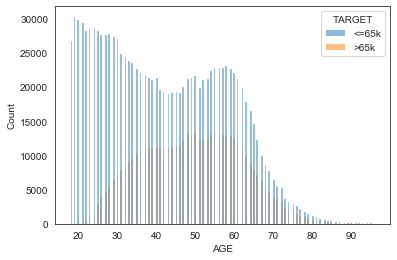

In [48]:
sns.histplot(data = df, x="AGE", hue = "TARGET")
plt.show()

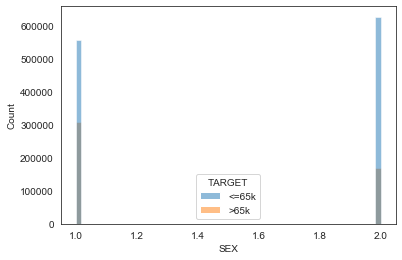

In [49]:
sns.histplot(data = df, x="SEX", hue = "TARGET")
plt.show()

In [50]:
df.SEX.value_counts()

1    865247
2    794480
Name: SEX, dtype: int64

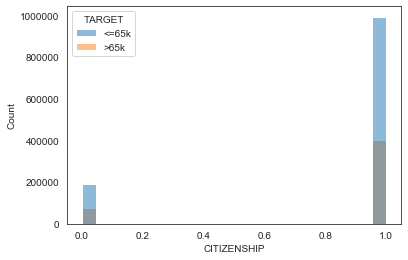

In [51]:
sns.histplot(data = df, x="CITIZENSHIP", hue = "TARGET")
plt.show()

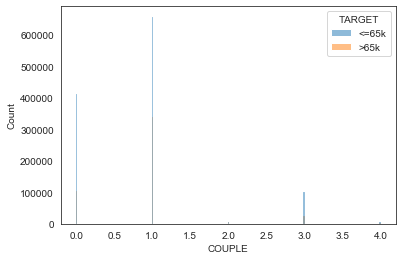

In [52]:
sns.histplot(data = df, x="COUPLE", hue = "TARGET")
plt.show()

- 1 - Opposite-sex husband/wife/spouse household
- 2 - Same-sex husband/wife/spouse household
- 3 - Opposite-sex unmarried partner household
- 4 - Same-sex unmarried partner household

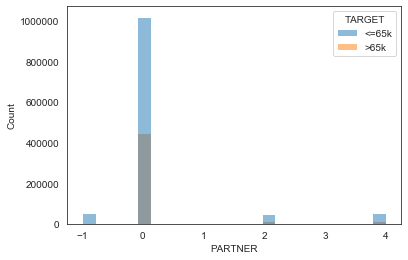

In [53]:
sns.histplot(data = df, x="PARTNER", hue = "TARGET")
plt.show()

- -1 - N/A (GQ/vacant)
- 0	- No unmarried partner in household
- 1	- Male householder, male partner
- 2	- Male householder, female partner
- 3	- Female householder, female partner
- 4	- Female householder, male partner

In [54]:
df.PARTNER.value_counts(normalize=True)

 0    0.884924
 4    0.038762
 2    0.038427
-1    0.033240
 3    0.002341
 1    0.002305
Name: PARTNER, dtype: float64

In [55]:
# sns.histplot(data = df, x="POB_WORLD", hue = "TARGET_60")

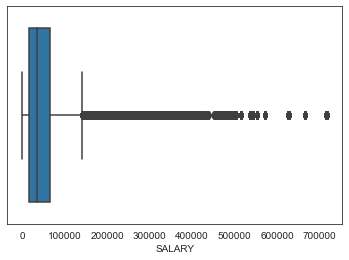

In [56]:
sns.boxplot(x=df.SALARY)


In [57]:
df.INCOME.median()

40240.0

In [58]:
df.SALARY.median()

35400.0

# Prepare Data for Modeling
- LabelEncoder for non-numeric features
- Remove unnecessary variables


In [59]:
# define cols
le = LabelEncoder()
cols = ['OCCUPATION', 'WORK_INDUSTRY', 'EDUCATION', 'RACE2', 'RACE3', 'AGE_DIV']
df.loc[:,cols] = df.loc[:,cols].apply(le.fit_transform)

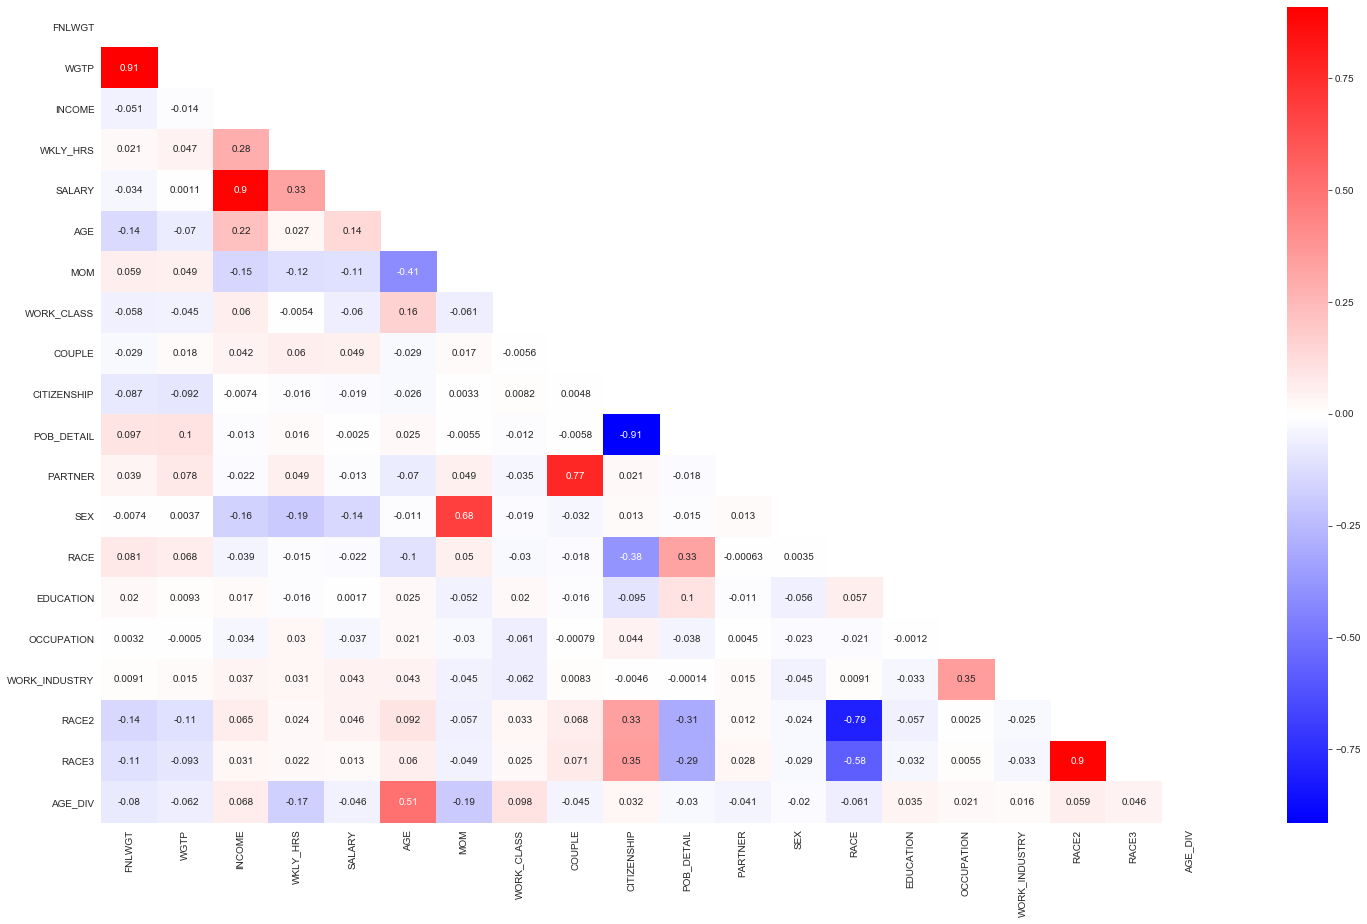

In [60]:
#Checking correlations heatmap for added features

fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [61]:
X = df.drop(['TARGET','INCOME', 'SALARY'], axis=1)
y = df.TARGET

In [62]:
df.head(2) #Sanity Check

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,WORK_CLASS,COUPLE,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY,RACE2,RACE3,AGE_DIV,TARGET
0,71,0,63000,80,63000,35,0,1,0,1,18,-1,1,1,3,4,1,1,4,0,<=65k
2,24,0,2000,15,2000,21,2,2,0,0,229,-1,2,6,3,23,2,0,0,0,<=65k


# Model Testing

## Baseline Model

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [64]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [65]:
accuracy_score(y_test, y_pred)

0.7544392816172288

In [66]:
importance = tree.feature_importances_
feat_imp_dict = dict(zip(X.columns, importance))

In [67]:
feat_imp_dict

{'FNLWGT': 0.11959715890068043,
 'WGTP': 0.11928332916704966,
 'WKLY_HRS': 0.12873818599168543,
 'AGE': 0.15814246128503473,
 'MOM': 0.0042243558777494365,
 'WORK_CLASS': 0.03160832905854792,
 'COUPLE': 0.020017991492454264,
 'CITIZENSHIP': 0.002826961629506523,
 'POB_DETAIL': 0.11245347287846325,
 'PARTNER': 0.007385999719271251,
 'SEX': 0.019821529063963363,
 'RACE': 0.009656180861807523,
 'EDUCATION': 0.06789459531474125,
 'OCCUPATION': 0.10925566646848406,
 'WORK_INDUSTRY': 0.07269069570782143,
 'RACE2': 0.003836186854712591,
 'RACE3': 0.010733012629929518,
 'AGE_DIV': 0.0018338870980973859}

## Decision Tree and GridSearch

In [68]:
# dt = DecisionTreeClassifier()
# dt_param_grid = {
#     'criterion' : ['gini', 'entropy'],
#     'max_depth' : [8, 9, 10, 11],
#     'min_samples_split' : [2, 5, 10],
#     'min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7, 8]
# }

In [69]:
# dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=3, verbose=True, n_jobs=-1)
# dt_grid_search.fit(X_train, y_train)

## LogisticRegression and GridSearch

In [70]:
# pipe = Pipeline([('logrg', LogisticRegression())])

# param_grid = {
#     'logrg__penalty' : ['l1', 'l2'],
#     'logrg__C' : [.01, .1, 1, 10, 100 ],
#     'logrg__solver' : ['liblinear', 'sag', 'saga'],
#     'logrg__max_iter' : [100, 200, 300]
# }

In [71]:
# clf = GridSearchCV(pipe, param_grid, cv = 3, verbose=True, n_jobs=-1)
# best_clf = clf.fit(X_train, y_train)

In [72]:
# best_clf.best_params_

In [73]:
# best_clf.best_score_

## RandomForest and GridSearch

In [74]:
# rf_clf = RandomForestClassifier()
# rf_param_grid = {
#     'n_estimators': [10, 30, 100],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 2, 6, 10],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [3, 6]
# }

In [75]:

# rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, verbose=True, n_jobs=-1)
# rf_grid_search.fit(X_train, y_train)

In [76]:
# rf_grid_search.best_params_

In [77]:
# rf_grid_search.best_score_

In [78]:
# rf_clf = RandomForestClassifier(criterion = 'gini', min_samples_split = 5, min_samples_leaf = 6)
# rf_clf.fit(X_train, y_train)

In [79]:
# y_pred = rf_clf.predict(X_test)
# accuracy_score(y_test, y_pred)

In [80]:
# def plot_feature_imporances(model):
#     n_features = X_train.shape[1]
#     plt.figure(figsize = (8,8))
#     plt.barh(range(n_features), model.feature_importances_, align = 'center')
#     plt.yticks(np.arange(n_features), X_train.columns.values)
#     plt.xlabel('Feature importance')
#     plt.ylabel('Feature')
    
# plot_feature_imporances(rf_clf)

## Model Evaluation Summary

In [81]:
# logrg_score = best_clf.score(X_test, y_test)
# dt_score = dt_grid_search.score(X_test, y_test)
# rf_score = rf_grid_search.score(X_test, y_test)


# print("Logistic regression grid search ", logrg_score)
# print("Decision tree grid search ", dt_score)
# print("Random forest grid search", rf_score)